In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from loss_function import CombinedLoss
from train_test import train_model
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets
from visualization import plot_mean_power_spectrum
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders
from qualitative_eval import mse, r2_score, pearson_corr

In [3]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
# import gcm_filters
import random

warnings.filterwarnings("ignore")

# importlib.reload(preprocessing)
# from preprocessing import preprocess_data

# from model_eval_plotting import evaluate_model
# from model_eval_plotting import plot_predictions_vs_targets

# from CNN_setup import SimpleCNN
# from CNN_setup import TensorDataset

# from gcm_filtering import filter_inputs_dataset
# from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [4]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

# Data Pre-processing

In [5]:
ds_HR = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR.zarr", engine="zarr", chunks={}) 
ds_LR = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR.zarr", engine="zarr", chunks={}) 
ds_HF = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF.zarr", engine="zarr", chunks={}) 

In [6]:
# Select region of interest
ds_HR_reg = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_LR_reg = ds_LR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_HF_reg = ds_HF.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))

# Case: u_rel Super-Resolution, MSELoss

In [13]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='u_relative', batch_size=32, normalization_type='normalization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [9]:
model = UNet()
model

UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv1_1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [154]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_case_urel_norm.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 8.703e-02, Val Loss: 1.740e-01, Epoch Time: 142.30s
Model saved at epoch 1
Epoch 2, Train Loss: 2.537e-02, Val Loss: 2.018e-02, Epoch Time: 139.88s
Model saved at epoch 2
Epoch 3, Train Loss: 2.318e-02, Val Loss: 1.489e-02, Epoch Time: 140.08s
Model saved at epoch 3
Epoch 4, Train Loss: 2.407e-02, Val Loss: 7.854e-03, Epoch Time: 139.81s
Model saved at epoch 4
Epoch 5, Train Loss: 1.930e-02, Val Loss: 8.801e-03, Epoch Time: 140.13s
Model saved at epoch 5
Epoch 6, Train Loss: 2.329e-02, Val Loss: 1.062e-02, Epoch Time: 179.26s
Model saved at epoch 6
Epoch 7, Train Loss: 2.055e-02, Val Loss: 8.185e-03, Epoch Time: 141.37s
Model saved at epoch 7
Epoch 8, Train Loss: 2.160e-02, Val Loss: 8.739e-03, Epoch Time: 140.24s
Model saved at epoch 8
Epoch 9, Train Loss: 2.468e-02, Val Loss: 6.641e-03, Epoch Time: 140.80s
Model saved at epoch 9
Epoch 10, Train Loss: 1.991e-02, Val Loss: 7.890e-03, Epoch Time: 145.95s
Model saved at epoch 10
Epoch 11

In [14]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_case_urel_norm.pth') #'./model_case_urel_norm.pth')
sr_pred

Loaded model parameters from ./model_case_urel_norm.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[0.3274423 , 0.35215625, 0.4933979 , ..., 0.4040683 ,
         0.35087022, 0.27505672],
        [0.48908937, 0.47331855, 0.5709806 , ..., 0.48067096,
         0.4222735 , 0.31020185],
        [0.52014124, 0.55846983, 0.5736653 , ..., 0.5028677 ,
         0.47995546, 0.41593862],
        ...,
        [0.35306755, 0.38245285, 0.31999433, ..., 0.46728614,
         0.49700698, 0.456187  ],
        [0.28328818, 0.3576262 , 0.34145194, ..., 0.4625221 ,
         0.49397606, 0.4696164 ],
        [0.31456003, 0.29430324, 0.30027524, ..., 0.4823069 ,
         0.404389  , 0.38411042]],

       [[0.35164553, 0.37775868, 0.5617981 , ..., 0.49608514,
         0.43224537, 0.33146596],
        [0.5339762 , 0.5214766 , 0.6272101 , ..., 0.5878146 ,
         0.51789635, 0.38394427],
        [0.5745719 , 0.59954715, 0.6208209 , ..., 0.5874028 ,
         0.5890163 , 0.5038284 ],
...
        [0.3883048 , 0.41734806, 0.353949  , ..., 0.23975897,
         0.23293874, 0.25176215],
        [0.31109804, 0.39906746, 0.3798669 , ..., 0.22673967,
         0.23460218, 0.26614922],
        [0.34649187, 0.3300653 , 0.3330198 , ..., 0.2372438 ,
         0.22239116, 0.21439879]],

       [[0.3073382 , 0.33295578, 0.4451915 , ..., 0.3966096 ,
         0.34146726, 0.2695843 ],
        [0.4480954 , 0.43958068, 0.52138245, ..., 0.4721311 ,
         0.4127135 , 0.3023426 ],
        [0.48144776, 0.5255676 , 0.5327057 , ..., 0.4982944 ,
         0.4705128 , 0.4037099 ],
        ...,
        [0.4517572 , 0.47840756, 0.42300034, ..., 0.58347166,
         0.62953013, 0.5674705 ],
        [0.3674379 , 0.47113276, 0.44635838, ..., 0.5726764 ,
         0.62646127, 0.58355916],
        [0.39767528, 0.38868776, 0.40223843, ..., 0.60473335,
         0.49043104, 0.47228155]]], shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0182-04-15 12:00:00 ... 0181-02-24 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

In [16]:
r2_scores_urel = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_urel)
best_r2 = r2_scores_urel[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9958 at index 27


In [17]:
min_val, max_val = norm_stats
urel_HR_test = HR_test * (max_val - min_val) + min_val
urel_LR_test = LR_test * (max_val - min_val) + min_val
urel_sr_pred = sr_pred * (max_val - min_val) + min_val

# Case: v_rel Super-Resolution, MSELoss

In [18]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='v_relative', batch_size=32, normalization_type='normalization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [163]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_case_vrel_norm.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 2.216e-01, Val Loss: 2.081e-01, Epoch Time: 148.81s
Model saved at epoch 1
Epoch 2, Train Loss: 3.503e-02, Val Loss: 2.372e-02, Epoch Time: 148.35s
Model saved at epoch 2
Epoch 3, Train Loss: 3.529e-02, Val Loss: 1.578e-02, Epoch Time: 145.58s
Model saved at epoch 3
Epoch 4, Train Loss: 2.814e-02, Val Loss: 1.528e-02, Epoch Time: 141.45s
Model saved at epoch 4
Epoch 5, Train Loss: 2.330e-02, Val Loss: 1.381e-02, Epoch Time: 143.76s
Model saved at epoch 5
Epoch 6, Train Loss: 2.014e-02, Val Loss: 1.599e-02, Epoch Time: 149.91s
Model saved at epoch 6
Epoch 7, Train Loss: 2.942e-02, Val Loss: 1.321e-02, Epoch Time: 144.86s
Model saved at epoch 7
Epoch 8, Train Loss: 2.895e-02, Val Loss: 1.603e-02, Epoch Time: 141.43s
Model saved at epoch 8
Epoch 9, Train Loss: 2.527e-02, Val Loss: 9.961e-03, Epoch Time: 141.01s
Model saved at epoch 9
Epoch 10, Train Loss: 2.417e-02, Val Loss: 2.224e-02, Epoch Time: 139.69s
Model saved at epoch 10
Epoch 11

In [19]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_case_vrel_norm.pth') # './model_case_vrel_norm.pth')
sr_pred

Loaded model parameters from ./model_case_vrel_norm.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[0.29912964, 0.48574325, 0.46827328, ..., 0.42269677,
         0.36361563, 0.28975135],
        [0.49704462, 0.5262363 , 0.5387312 , ..., 0.45558226,
         0.4319345 , 0.35968181],
        [0.5874469 , 0.61546004, 0.58979696, ..., 0.4322837 ,
         0.42539933, 0.41108248],
        ...,
        [0.43977332, 0.43909478, 0.45635667, ..., 0.31792635,
         0.2598161 , 0.26853362],
        [0.3492695 , 0.36762863, 0.46472424, ..., 0.30310607,
         0.2786379 , 0.2749073 ],
        [0.19597115, 0.31295487, 0.3511476 , ..., 0.26383442,
         0.1959    , 0.12279589]],

       [[0.18534248, 0.3080364 , 0.28244832, ..., 0.61689395,
         0.5732351 , 0.44299573],
        [0.29360574, 0.34317675, 0.34230807, ..., 0.6803169 ,
         0.7113666 , 0.5661245 ],
        [0.3658195 , 0.40138668, 0.3803853 , ..., 0.64657295,
         0.6543001 , 0.6082246 ],
...
        [0.6485892 , 0.6611184 , 0.68190765, ..., 0.29915518,
         0.23874614, 0.25425076],
        [0.5482099 , 0.56338614, 0.6753317 , ..., 0.27997634,
         0.25508618, 0.25595433],
        [0.3463085 , 0.52120554, 0.54714143, ..., 0.22999632,
         0.16706249, 0.10688455]],

       [[0.31478146, 0.513235  , 0.5012071 , ..., 0.6516315 ,
         0.61634797, 0.4682495 ],
        [0.54011565, 0.5640319 , 0.5853894 , ..., 0.73283243,
         0.7573336 , 0.5983806 ],
        [0.634794  , 0.6507189 , 0.6286899 , ..., 0.6894377 ,
         0.7031057 , 0.63725424],
        ...,
        [0.30396196, 0.2909832 , 0.3052775 , ..., 0.40041602,
         0.32174662, 0.34030747],
        [0.22981134, 0.23296857, 0.31401125, ..., 0.38986698,
         0.34760952, 0.35365653],
        [0.10766971, 0.18608373, 0.22045705, ..., 0.35256803,
         0.28417897, 0.18528077]]], shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0182-04-05 12:00:00 ... 0182-02-11 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

In [20]:
r2_scores_vrel = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_vrel)
best_r2 = r2_scores_vrel[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9963 at index 78


In [22]:
min_val, max_val = norm_stats
vrel_HR_test = HR_test * (max_val - min_val) + min_val
vrel_LR_test = LR_test * (max_val - min_val) + min_val
vrel_sr_pred = sr_pred * (max_val - min_val) + min_val

# Case: t_ref Super-Resolution, MSELoss

In [23]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='t_ref', batch_size=32, normalization_type='normalization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [171]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_case_tref_norm.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 2314881
Resuming from epoch 50 with best val losses [0.0009950785919032785, 0.0009287830811728715, 0.0010068399368127416, 0.0010412684433512526, 0.0008767906799613404]
Training complete


In [24]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_case_tref_norm.pth')
sr_pred

Loaded model parameters from ./model_case_tref_norm.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[0.5535592 , 0.8520608 , 0.8821211 , ..., 0.8014544 ,
         0.7840804 , 0.54963696],
        [0.7113313 , 0.78973347, 0.82496524, ..., 0.75833344,
         0.74046016, 0.8279142 ],
        [0.83042854, 0.8533366 , 0.8825113 , ..., 0.8242798 ,
         0.703758  , 0.8606172 ],
        ...,
        [0.11255332, 0.19408129, 0.1676934 , ..., 0.3025031 ,
         0.25171703, 0.21244663],
        [0.11263281, 0.19438659, 0.18478493, ..., 0.242702  ,
         0.25399095, 0.20701951],
        [0.00733784, 0.09455885, 0.07087294, ..., 0.13118467,
         0.12617421, 0.02333539]],

       [[0.62504196, 0.94954604, 0.9732468 , ..., 0.8447482 ,
         0.8322139 , 0.5829489 ],
        [0.79345167, 0.8838898 , 0.924707  , ..., 0.8018238 ,
         0.7849481 , 0.87571007],
        [0.93217653, 0.9617299 , 0.9812105 , ..., 0.8667335 ,
         0.7458053 , 0.9057711 ],
...
        [0.2601409 , 0.30691767, 0.28307158, ..., 0.39660442,
         0.34251282, 0.35193327],
        [0.19858809, 0.26290372, 0.2802591 , ..., 0.31214195,
         0.3094371 , 0.27569574],
        [0.04060351, 0.17337593, 0.15213262, ..., 0.17940192,
         0.176685  , 0.04796701]],

       [[0.56985146, 0.87389994, 0.9023212 , ..., 0.8071393 ,
         0.790301  , 0.55382717],
        [0.7298227 , 0.8112279 , 0.84728086, ..., 0.76378775,
         0.74602944, 0.8342647 ],
        [0.85404813, 0.87827003, 0.9052328 , ..., 0.82989   ,
         0.70946074, 0.86627674],
        ...,
        [0.09823375, 0.17026359, 0.14304827, ..., 0.2845969 ,
         0.23468673, 0.1921664 ],
        [0.10529685, 0.17990138, 0.16655053, ..., 0.23124623,
         0.23895907, 0.19313243],
        [0.00153829, 0.08348317, 0.0557432 , ..., 0.11947539,
         0.11204992, 0.01707854]]], shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0181-02-28 12:00:00 ... 0181-03-12 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

In [25]:
r2_scores_tref = r2_per_sample(HR_test.values, sr_pred.values)
r2_scores_tref

array([0.98900706, 0.99122387, 0.98511809, 0.99249423, 0.99010867,
       0.99387854, 0.99124718, 0.9855693 , 0.97237825, 0.99377412,
       0.97042274, 0.99052531, 0.99142236, 0.98583603, 0.97054964,
       0.99171847, 0.98872942, 0.98942977, 0.99211013, 0.99084073,
       0.9889819 , 0.99065071, 0.99431944, 0.98819703, 0.99425972,
       0.99379045, 0.98365682, 0.99152148, 0.99385798, 0.98701477,
       0.99303806, 0.98917443, 0.99503553, 0.98029083, 0.98048103,
       0.98850715, 0.99106622, 0.97728676, 0.98933893, 0.99055386,
       0.99006826, 0.99053806, 0.99125582, 0.99541265, 0.98195124,
       0.98891568, 0.99267042, 0.99135005, 0.99327195, 0.98257804,
       0.98676693, 0.9940356 , 0.97374564, 0.99237657, 0.98598129,
       0.99614984, 0.98413616, 0.99149728, 0.9746002 , 0.9789359 ,
       0.99437439, 0.99149668, 0.98305827, 0.9727729 , 0.98749542,
       0.98766768, 0.97986126, 0.98303151, 0.99266714, 0.97199112,
       0.99289113, 0.98211843, 0.9915027 , 0.9737826 , 0.98973

In [26]:
best_index = np.argmax(r2_scores_tref)
best_r2 = r2_scores_tref[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9968 at index 95


In [27]:
min_val, max_val = norm_stats
tref_HR_test = HR_test * (max_val - min_val) + min_val
tref_LR_test = LR_test * (max_val - min_val) + min_val
tref_sr_pred = sr_pred * (max_val - min_val) + min_val

# Case: q_ref Super-Resolution, MSELoss

In [55]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='q_ref', batch_size=32, normalization_type='normalization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [180]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_case_qref_norm.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 2314881
Resuming from epoch 49 with best val losses [0.0021907106125214643, 0.0019086133720729193, 0.0017495415100844901, 0.0019493097110454916, 0.0016648671867479697]
Epoch 50, Train Loss: 1.065e-02, Val Loss: 2.561e-03, Epoch Time: 140.16s
Patience counter: 1/50
Training complete


In [56]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_case_qref_norm.pth')
sr_pred

Loaded model parameters from ./model_case_qref_norm.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[0.39610782, 0.5327747 , 0.6423476 , ..., 0.6390983 ,
         0.6049869 , 0.5412616 ],
        [0.48000777, 0.54617673, 0.60950327, ..., 0.68499285,
         0.620621  , 0.7465032 ],
        [0.5807888 , 0.62110436, 0.651644  , ..., 0.74101573,
         0.6854289 , 0.74657196],
        ...,
        [0.15231936, 0.2032372 , 0.21465352, ..., 0.20231189,
         0.22071622, 0.18611771],
        [0.1694348 , 0.12059152, 0.18698142, ..., 0.12165708,
         0.17162687, 0.12054807],
        [0.11521689, 0.12764886, 0.18298772, ..., 0.08932128,
         0.14563382, 0.07575202]],

       [[0.5589478 , 0.75829965, 0.87204295, ..., 0.7132278 ,
         0.66217643, 0.59172904],
        [0.66055226, 0.7688003 , 0.82703817, ..., 0.74522364,
         0.6692238 , 0.80079895],
        [0.82538104, 0.8509739 , 0.85356283, ..., 0.7992452 ,
         0.73720086, 0.82324797],
...
        [0.13736302, 0.16964519, 0.18593158, ..., 0.102289  ,
         0.12184196, 0.13777603],
        [0.15320951, 0.10128727, 0.1690855 , ..., 0.03690057,
         0.10884708, 0.04503408],
        [0.10128035, 0.1168419 , 0.17218217, ..., 0.03638811,
         0.07773732, 0.02799762]],

       [[0.5219622 , 0.70692027, 0.82591057, ..., 0.5455442 ,
         0.53789485, 0.48334667],
        [0.6133545 , 0.72241163, 0.7812115 , ..., 0.5918831 ,
         0.55123186, 0.6657678 ],
        [0.7750412 , 0.8001102 , 0.8068181 , ..., 0.6494128 ,
         0.60559344, 0.6437881 ],
        ...,
        [0.10197412, 0.08746328, 0.13748851, ..., 0.18148229,
         0.20350109, 0.17859387],
        [0.11326642, 0.05775894, 0.11653478, ..., 0.11002855,
         0.16465229, 0.10804908],
        [0.07409722, 0.08176005, 0.14502153, ..., 0.08046622,
         0.13947098, 0.06972468]]], shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0182-06-10 12:00:00 ... 0182-11-17 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

In [57]:
r2_scores_qref = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_qref)
best_r2 = r2_scores_qref[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9906 at index 56


In [58]:
min_val, max_val = norm_stats
qref_HR_test = HR_test * (max_val - min_val) + min_val
qref_LR_test = LR_test * (max_val - min_val) + min_val
qref_sr_pred = sr_pred * (max_val - min_val) + min_val

# Case: SLP Super-Resolution, MSELoss

In [59]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='slp', batch_size=32, normalization_type='normalization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [186]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_case_slp_norm.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 2314881
Resuming from epoch 32 with best val losses [0.0028304948509935667, 0.0011622630211379414]
Epoch 33, Train Loss: 2.136e-02, Val Loss: 1.834e-03, Epoch Time: 141.18s
Epoch 34, Train Loss: 3.295e-02, Val Loss: 1.239e-03, Epoch Time: 140.64s
Epoch 35, Train Loss: 2.693e-02, Val Loss: 9.148e-04, Epoch Time: 142.06s
Best model so far saved to ./model_case_slp_norm.pth
Epoch 36, Train Loss: 2.405e-02, Val Loss: 1.895e-03, Epoch Time: 140.92s
Epoch 37, Train Loss: 3.393e-02, Val Loss: 2.224e-03, Epoch Time: 138.16s
Patience counter: 1/50
Epoch 38, Train Loss: 2.035e-02, Val Loss: 9.600e-04, Epoch Time: 139.54s
Epoch 39, Train Loss: 2.829e-02, Val Loss: 1.477e-03, Epoch Time: 139.82s
Epoch 40, Train Loss: 3.289e-02, Val Loss: 1.810e-03, Epoch Time: 138.19s
Patience counter: 1/50
Epoch 41, Train Loss: 3.310e-02, Val Loss: 1.808e-03, Epoch Time: 139.38s
Patience counter: 2/50
Epoch 42, Train Loss: 2.222e-02, Val Loss: 8.641e-04, Epoch Time: 139.10s
Best model so far

In [60]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_case_slp_norm.pth')
sr_pred

Loaded model parameters from ./model_case_slp_norm.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[0.35609722, 0.44405916, 0.47159994, ..., 0.49266103,
         0.4138982 , 0.2965461 ],
        [0.54601985, 0.6024571 , 0.5923388 , ..., 0.66102403,
         0.5495779 , 0.6133859 ],
        [0.5958416 , 0.65884316, 0.6853344 , ..., 0.695594  ,
         0.7057161 , 0.70967346],
        ...,
        [0.39862567, 0.3761759 , 0.3570972 , ..., 0.6415794 ,
         0.57505804, 0.56193435],
        [0.33166412, 0.3029201 , 0.34005964, ..., 0.6456321 ,
         0.5399437 , 0.52956223],
        [0.229546  , 0.3093639 , 0.34726566, ..., 0.5472978 ,
         0.5833031 , 0.4515292 ]],

       [[0.35767418, 0.44542417, 0.47450113, ..., 0.49408144,
         0.415159  , 0.29714188],
        [0.54840565, 0.60502625, 0.59627575, ..., 0.6647286 ,
         0.5523063 , 0.61556107],
        [0.599473  , 0.6625964 , 0.6908247 , ..., 0.6990315 ,
         0.70867324, 0.7118287 ],
...
        [0.64114636, 0.61647844, 0.62218064, ..., 0.48412552,
         0.4321101 , 0.43965542],
        [0.54470354, 0.59247184, 0.5672925 , ..., 0.47820458,
         0.42944428, 0.4015333 ],
        [0.3529817 , 0.5142952 , 0.6057925 , ..., 0.41837472,
         0.4314178 , 0.3535074 ]],

       [[0.37308714, 0.46177548, 0.4955895 , ..., 0.5179899 ,
         0.43595648, 0.31301865],
        [0.57566327, 0.6374975 , 0.6316395 , ..., 0.71914774,
         0.5973558 , 0.66077185],
        [0.6319618 , 0.7019031 , 0.7321907 , ..., 0.75548536,
         0.76335794, 0.7647088 ],
        ...,
        [0.56738245, 0.5364107 , 0.5458607 , ..., 0.74787617,
         0.6722119 , 0.64323115],
        [0.47029865, 0.5063449 , 0.48820403, ..., 0.7575399 ,
         0.6234568 , 0.6203827 ],
        [0.3026872 , 0.44678682, 0.52324045, ..., 0.64168245,
         0.6830963 , 0.5154681 ]]], shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0181-09-10 12:00:00 ... 0182-03-06 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

In [61]:
r2_scores_slp = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_slp)
best_r2 = r2_scores_slp[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9913 at index 90


In [62]:
min_val, max_val = norm_stats
slp_HR_test = HR_test * (max_val - min_val) + min_val
slp_LR_test = LR_test * (max_val - min_val) + min_val
slp_sr_pred = sr_pred * (max_val - min_val) + min_val

# Case: SST Super-Resolution, MSELoss

In [37]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='surface_temp', batch_size=32, normalization_type='normalization')

Training set size: 510
Validation set size: 109
Testing set size: 111


In [192]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_case_sst_norm.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 2314881
Resuming from epoch 30 with best val losses []
Epoch 31, Train Loss: 1.014e-02, Val Loss: 4.980e-03, Epoch Time: 139.70s
Best model so far saved to ./model_case_sst_norm.pth
Epoch 32, Train Loss: 1.115e-02, Val Loss: 6.798e-03, Epoch Time: 139.99s
Epoch 33, Train Loss: 9.643e-03, Val Loss: 6.193e-03, Epoch Time: 140.29s
Epoch 34, Train Loss: 9.974e-03, Val Loss: 4.503e-03, Epoch Time: 140.39s
Best model so far saved to ./model_case_sst_norm.pth
Epoch 35, Train Loss: 9.632e-03, Val Loss: 4.527e-03, Epoch Time: 140.62s
Epoch 36, Train Loss: 1.571e-02, Val Loss: 5.280e-03, Epoch Time: 140.59s
Epoch 37, Train Loss: 1.311e-02, Val Loss: 4.692e-03, Epoch Time: 140.57s
Epoch 38, Train Loss: 7.932e-03, Val Loss: 4.512e-03, Epoch Time: 139.96s
Epoch 39, Train Loss: 7.697e-03, Val Loss: 4.789e-03, Epoch Time: 140.96s
Epoch 40, Train Loss: 7.919e-03, Val Loss: 4.410e-03, Epoch Time: 141.01s
Best model so far saved to ./model_case_sst_norm.pth
Epoch 41, Train Loss: 9.

In [38]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_case_sst_norm.pth')
sr_pred

Loaded model parameters from ./model_case_sst_norm.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[ 7.35783815e-01,  9.36684251e-01,  9.37526047e-01, ...,
          9.01825309e-01,  8.09245884e-01,  7.21955299e-01],
        [ 8.57913733e-01,  9.26997900e-01,  1.02768767e+00, ...,
          9.01277840e-01,  8.93952906e-01,  8.59786630e-01],
        [ 9.98396158e-01,  9.45443511e-01,  1.00798213e+00, ...,
          8.77895594e-01,  8.89905334e-01,  8.23377073e-01],
        ...,
        [ 8.16105455e-02,  7.99334347e-02,  1.02617368e-01, ...,
          1.62640572e-01,  1.98247626e-01,  1.84714198e-01],
        [ 2.74473205e-02,  1.10567007e-02, -1.43212248e-02, ...,
          6.22150153e-02,  5.67873940e-02,  5.80964722e-02],
        [-8.18453878e-02, -7.59260803e-02, -7.51549900e-02, ...,
         -2.79969350e-02, -4.91970219e-02, -9.79038849e-02]],

       [[ 6.32398367e-01,  8.06617916e-01,  8.05085599e-01, ...,
          8.49572420e-01,  7.59881735e-01,  6.80509388e-01],
        [ 7.33825326e-01,  8.08958650e-01,  9.03551936e-01, ...,
          8.47986937e-01,  8.44489813e-01,  8.06144595e-01],
        [ 8.59341383e-01,  8.11486483e-01,  8.73467207e-01, ...,
          8.24635208e-01,  8.31463158e-01,  7.74282694e-01],
...
          2.95018375e-01,  3.25406611e-01,  2.90908039e-01],
        [ 4.99916524e-02,  2.23720931e-02,  7.95862451e-03, ...,
          1.21284604e-01,  1.22481368e-01,  1.11809313e-01],
        [-9.30884629e-02, -9.85093117e-02, -8.80273283e-02, ...,
         -1.43059082e-02, -4.52283882e-02, -9.13402736e-02]],

       [[ 6.63920879e-01,  8.45949531e-01,  8.45088243e-01, ...,
          8.46496463e-01,  7.56990135e-01,  6.78028464e-01],
        [ 7.71423757e-01,  8.44613731e-01,  9.41074967e-01, ...,
          8.44831645e-01,  8.41506124e-01,  8.02880466e-01],
        [ 9.01410460e-01,  8.52632582e-01,  9.13855433e-01, ...,
          8.21339369e-01,  8.27745616e-01,  7.71200538e-01],
        ...,
        [ 4.73448522e-02,  6.76999837e-02,  6.19467646e-02, ...,
          9.67972353e-02,  1.44276991e-01,  1.39930025e-01],
        [ 1.88101493e-02, -3.47806141e-04, -1.81509089e-02, ...,
          3.89836654e-02,  2.71879975e-02,  2.83748154e-02],
        [-7.79671818e-02, -6.93252459e-02, -6.76969364e-02, ...,
         -3.67663316e-02, -5.53542674e-02, -9.96818021e-02]]],
      shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0181-11-01 12:00:00 ... 0182-05-27 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

In [39]:
r2_scores_sst = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_sst)
best_r2 = r2_scores_sst[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9854 at index 50


In [40]:
min_val, max_val = norm_stats
sst_HR_test = HR_test * (max_val - min_val) + min_val
sst_LR_test = LR_test * (max_val - min_val) + min_val
sst_sr_pred = sr_pred * (max_val - min_val) + min_val

# Figures

In [63]:
# Suppose you have 6 arrays: a1, a2, ..., a6 (all same length)
arrays = [r2_scores_urel, r2_scores_vrel, r2_scores_tref, r2_scores_qref, r2_scores_slp, r2_scores_sst]

# Stack into shape (6, N) and take mean over axis=0
mean_array = np.mean(np.stack(arrays, axis=0), axis=0)

# Find the max value and its index
max_val = np.max(mean_array)
max_idx = np.argmax(mean_array)

print(f"Max value = {max_val}, at index = {max_idx}")

Max value = 0.9869578580061594, at index = 78


In [64]:
# Find the min value and its index
min_val = np.min(mean_array)
min_idx = np.argmin(mean_array)

print(f"Min value = {min_val}, at index = {min_idx}")

Min value = 0.8207362989584605, at index = 19


In [67]:
# Make a Dataset
ds_unet_norm = xr.Dataset()

# Manually add variables
ds_unet_norm["u_rel_sr"] = (("time", "y", "x"), urel_sr_pred.values)
ds_unet_norm["v_rel_sr"] = (("time", "y", "x"), vrel_sr_pred.values)
ds_unet_norm["t_ref_sr"] = (("time", "y", "x"), tref_sr_pred.values)
ds_unet_norm["q_ref_sr"] = (("time", "y", "x"), qref_sr_pred.values)
ds_unet_norm["slp_sr"] = (("time", "y", "x"), slp_sr_pred.values)
ds_unet_norm["sst_sr"] = (("time", "y", "x"), sst_sr_pred.values)

ds_unet_norm["u_rel_hr"] = (("time", "y", "x"), urel_HR_test.values)
ds_unet_norm["v_rel_hr"] = (("time", "y", "x"), vrel_HR_test.values)
ds_unet_norm["t_ref_hr"] = (("time", "y", "x"), tref_HR_test.values)
ds_unet_norm["q_ref_hr"] = (("time", "y", "x"), qref_HR_test.values)
ds_unet_norm["slp_hr"] = (("time", "y", "x"), slp_HR_test.values)
ds_unet_norm["sst_hr"] = (("time", "y", "x"), sst_HR_test.values)

ds_unet_norm["u_rel_lr"] = (("time", "y", "x"), urel_LR_test)
ds_unet_norm["v_rel_lr"] = (("time", "y", "x"), vrel_LR_test)
ds_unet_norm["t_ref_lr"] = (("time", "y", "x"), tref_LR_test)
ds_unet_norm["q_ref_lr"] = (("time", "y", "x"), qref_LR_test)
ds_unet_norm["slp_lr"] = (("time", "y", "x"), slp_LR_test)
ds_unet_norm["sst_lr"] = (("time", "y", "x"), sst_LR_test)

print(ds_unet_norm)

<xarray.Dataset> Size: 480MB
Dimensions:   (time: 111, y: 300, x: 200)
Dimensions without coordinates: time, y, x
Data variables: (12/18)
    u_rel_sr  (time, y, x) float32 27MB -8.765 -7.642 -1.223 ... -1.358 -2.183
    v_rel_sr  (time, y, x) float32 27MB -8.133 -0.9333 -1.607 ... -8.71 -12.53
    t_ref_sr  (time, y, x) float32 27MB 285.7 294.6 295.4 ... 272.9 272.6 269.8
    q_ref_sr  (time, y, x) float32 27MB 0.008436 0.01074 ... 0.004106 0.00293
    slp_sr    (time, y, x) float32 27MB 9.851e+04 9.933e+04 ... 1.016e+05 1e+05
    sst_sr    (time, y, x) float32 27MB 293.9 299.0 299.0 ... 274.3 273.9 272.8
    ...        ...
    u_rel_lr  (time, y, x) float32 27MB 0.8969 0.8623 0.8255 ... 2.89 2.905
    v_rel_lr  (time, y, x) float32 27MB 0.683 0.6084 0.5347 ... -5.761 -5.679
    t_ref_lr  (time, y, x) float32 27MB 293.9 293.9 293.9 ... 278.3 278.3 278.3
    q_ref_lr  (time, y, x) float32 27MB 0.01177 0.01179 ... 0.004921 0.004916
    slp_lr    (time, y, x) float32 27MB 1.015e+05 1.015

In [69]:
ds_unet_norm.to_zarr("gs://leap-persistent/panalluri/unet_norm_fluxInputs_all.zarr", zarr_version=2)

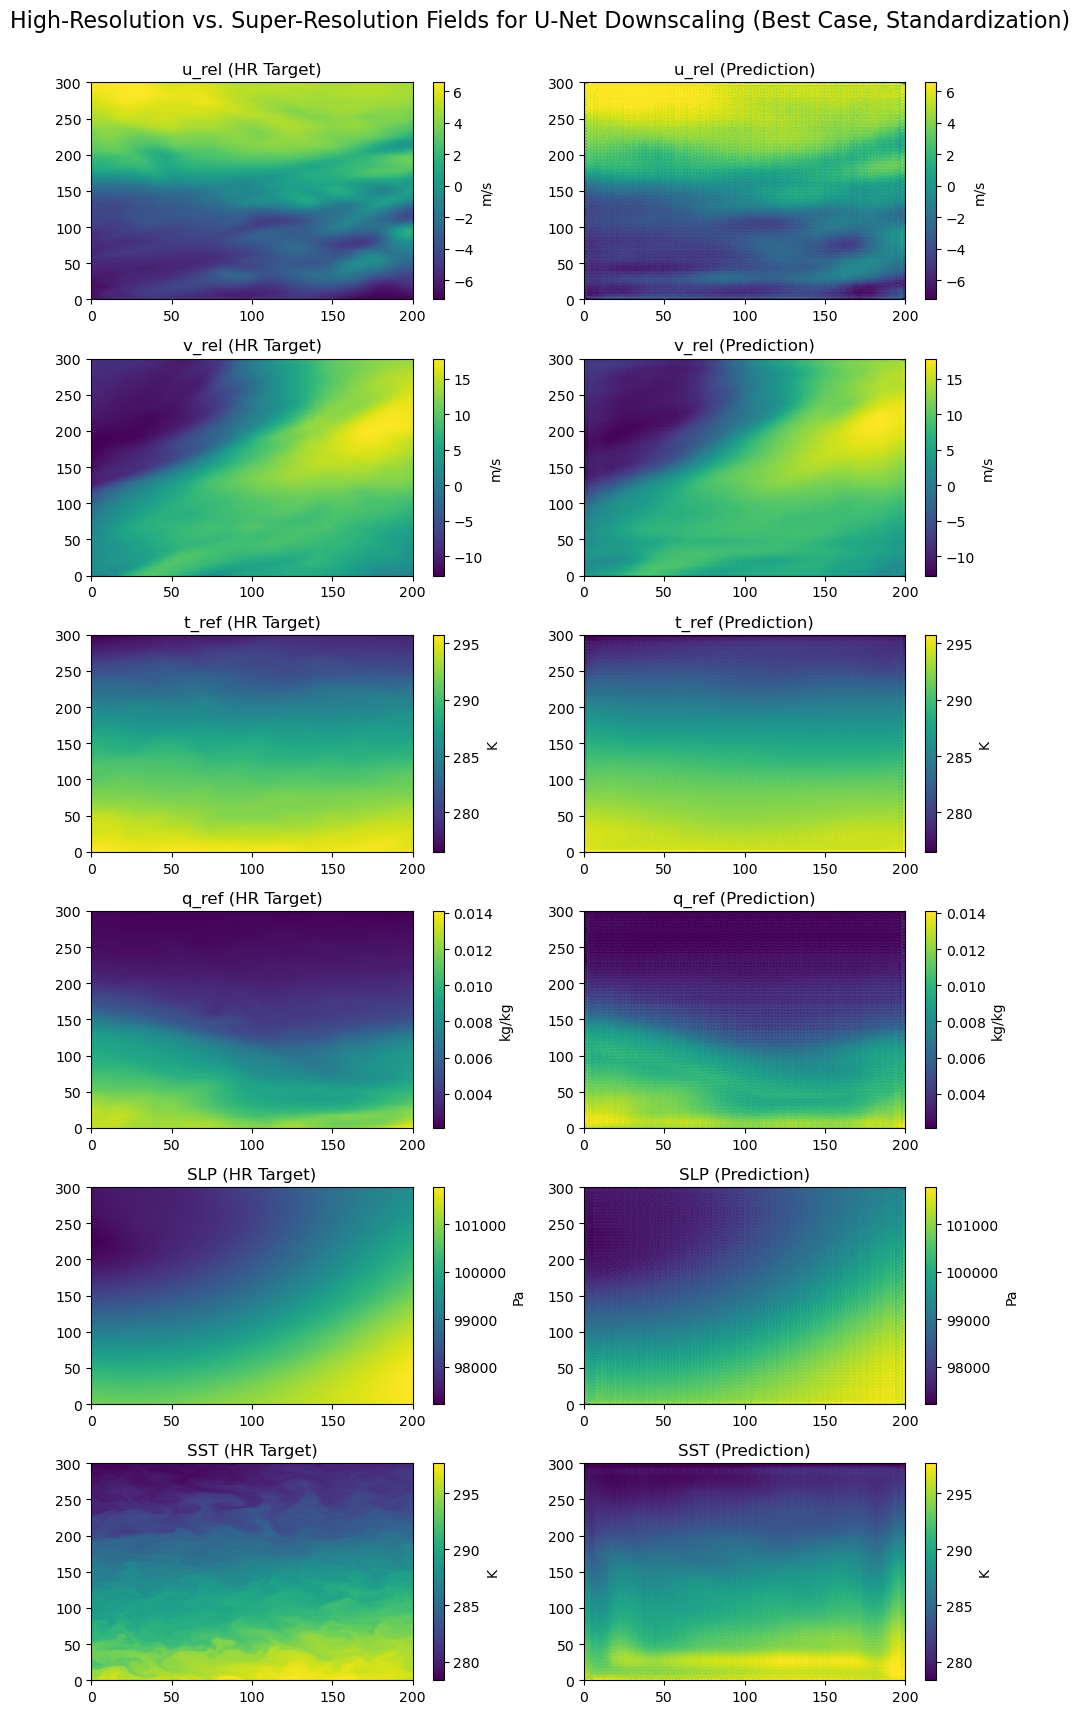

In [74]:
fig, axes = plt.subplots(6, 2, figsize=(10, 18))

vmins = [urel_HR_test[max_idx].min().values, vrel_HR_test[max_idx].min().values, tref_HR_test[max_idx].min().values,
         qref_HR_test[max_idx].min().values, slp_HR_test[max_idx].min().values, sst_HR_test[max_idx].min().values]
vmaxs = [urel_HR_test[max_idx].max().values, vrel_HR_test[max_idx].max().values, tref_HR_test[max_idx].max().values,
         qref_HR_test[max_idx].max().values, slp_HR_test[max_idx].max().values, sst_HR_test[max_idx].max().values]

# Add figure-level title
fig.suptitle("High-Resolution vs. Super-Resolution Fields for U-Net Downscaling (Best Case, Standardization)", fontsize=16, y=0.95)

# Top-left
im = axes[0, 0].pcolor(urel_HR_test[max_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 0].set_title("u_rel (HR Target)")
fig.colorbar(im, ax=axes[0, 0], label="m/s")

# Top-right
im = axes[0, 1].pcolor(urel_sr_pred[max_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 1].set_title("u_rel (Prediction)")
fig.colorbar(im, ax=axes[0, 1], label="m/s")

# Second row
im = axes[1, 0].pcolor(vrel_HR_test[max_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 0].set_title("v_rel (HR Target)")
fig.colorbar(im, ax=axes[1, 0], label="m/s")

im = axes[1, 1].pcolor(vrel_sr_pred[max_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 1].set_title("v_rel (Prediction)")
fig.colorbar(im, ax=axes[1, 1], label="m/s")

# Third row
im = axes[2, 0].pcolor(tref_HR_test[max_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 0].set_title("t_ref (HR Target)")
fig.colorbar(im, ax=axes[2, 0], label="K")

im = axes[2, 1].pcolor(tref_sr_pred[max_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 1].set_title("t_ref (Prediction)")
fig.colorbar(im, ax=axes[2, 1], label="K")

# Fourth row
im = axes[3, 0].pcolor(qref_HR_test[max_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 0].set_title("q_ref (HR Target)")
fig.colorbar(im, ax=axes[3, 0], label="kg/kg")

im = axes[3, 1].pcolor(qref_sr_pred[max_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 1].set_title("q_ref (Prediction)")
fig.colorbar(im, ax=axes[3, 1], label="kg/kg")

# Fifth row
im = axes[4, 0].pcolor(slp_HR_test[max_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 0].set_title("SLP (HR Target)")
fig.colorbar(im, ax=axes[4, 0], label="Pa")

im = axes[4, 1].pcolor(slp_sr_pred[max_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 1].set_title("SLP (Prediction)")
fig.colorbar(im, ax=axes[4, 1], label="Pa")

# Sixth row
im = axes[5, 0].pcolor(sst_HR_test[max_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 0].set_title("SST (HR Target)")
fig.colorbar(im, ax=axes[5, 0], label="K")

im = axes[5, 1].pcolor(sst_sr_pred[max_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 1].set_title("SST (Prediction)")
fig.colorbar(im, ax=axes[5, 1], label="K")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

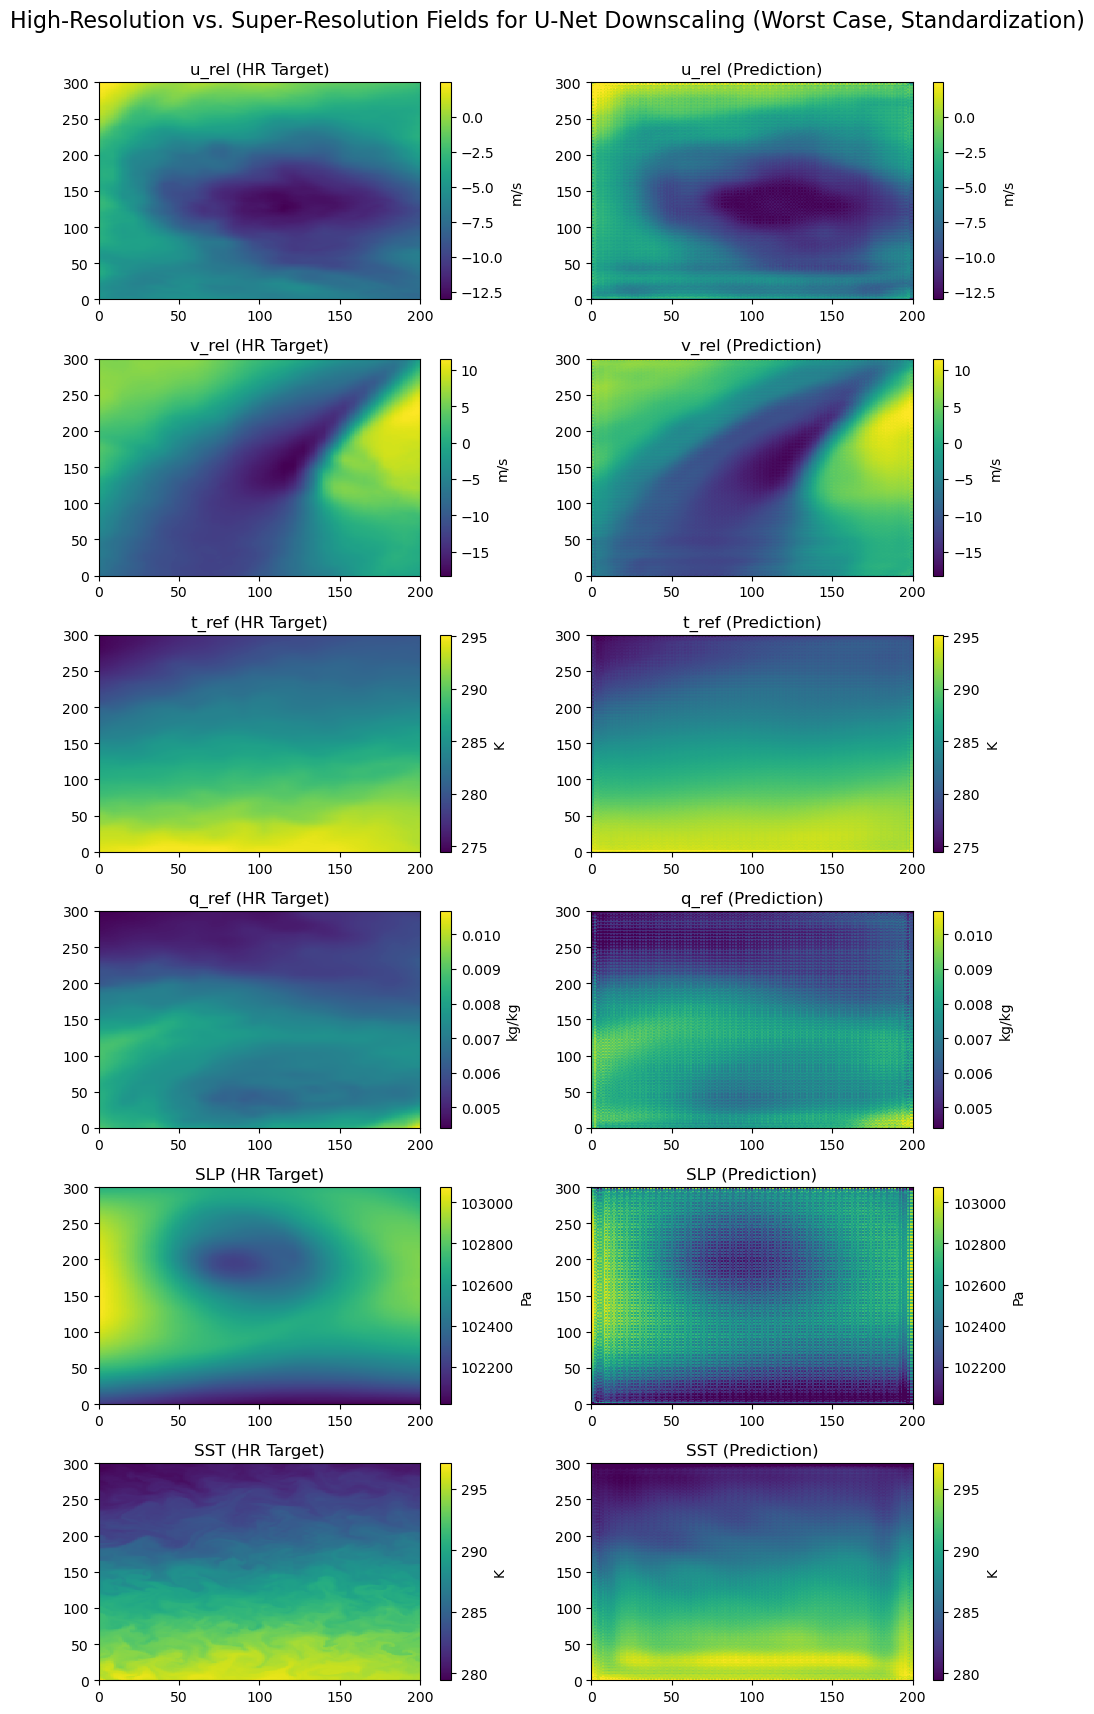

In [73]:
fig, axes = plt.subplots(6, 2, figsize=(10, 18))

vmins = [urel_HR_test[min_idx].min().values, vrel_HR_test[min_idx].min().values, tref_HR_test[min_idx].min().values,
         qref_HR_test[min_idx].min().values, slp_HR_test[min_idx].min().values, sst_HR_test[min_idx].min().values]
vmaxs = [urel_HR_test[min_idx].max().values, vrel_HR_test[min_idx].max().values, tref_HR_test[min_idx].max().values,
         qref_HR_test[min_idx].max().values, slp_HR_test[min_idx].max().values, sst_HR_test[min_idx].max().values]

# Add figure-level title
fig.suptitle("High-Resolution vs. Super-Resolution Fields for U-Net Downscaling (Worst Case, Standardization)", fontsize=16, y=0.95)

# Top-left
im = axes[0, 0].pcolor(urel_HR_test[min_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 0].set_title("u_rel (HR Target)")
fig.colorbar(im, ax=axes[0, 0], label="m/s")

# Top-right
im = axes[0, 1].pcolor(urel_sr_pred[min_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 1].set_title("u_rel (Prediction)")
fig.colorbar(im, ax=axes[0, 1], label="m/s")

# Second row
im = axes[1, 0].pcolor(vrel_HR_test[min_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 0].set_title("v_rel (HR Target)")
fig.colorbar(im, ax=axes[1, 0], label="m/s")

im = axes[1, 1].pcolor(vrel_sr_pred[min_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 1].set_title("v_rel (Prediction)")
fig.colorbar(im, ax=axes[1, 1], label="m/s")

# Third row
im = axes[2, 0].pcolor(tref_HR_test[min_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 0].set_title("t_ref (HR Target)")
fig.colorbar(im, ax=axes[2, 0], label="K")

im = axes[2, 1].pcolor(tref_sr_pred[min_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 1].set_title("t_ref (Prediction)")
fig.colorbar(im, ax=axes[2, 1], label="K")

# Fourth row
im = axes[3, 0].pcolor(qref_HR_test[min_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 0].set_title("q_ref (HR Target)")
fig.colorbar(im, ax=axes[3, 0], label="kg/kg")

im = axes[3, 1].pcolor(qref_sr_pred[min_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 1].set_title("q_ref (Prediction)")
fig.colorbar(im, ax=axes[3, 1], label="kg/kg")

# Fifth row
im = axes[4, 0].pcolor(slp_HR_test[min_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 0].set_title("SLP (HR Target)")
fig.colorbar(im, ax=axes[4, 0], label="Pa")

im = axes[4, 1].pcolor(slp_sr_pred[min_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 1].set_title("SLP (Prediction)")
fig.colorbar(im, ax=axes[4, 1], label="Pa")

# Sixth row
im = axes[5, 0].pcolor(sst_HR_test[min_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 0].set_title("SST (HR Target)")
fig.colorbar(im, ax=axes[5, 0], label="K")

im = axes[5, 1].pcolor(sst_sr_pred[min_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 1].set_title("SST (Prediction)")
fig.colorbar(im, ax=axes[5, 1], label="K")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# SGS HF Contribution Plots

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import aerobulk
from aerobulk import noskin

In [2]:
def r2(y_true, y_pred):
    
    yt = y_true.reshape(-1)
    yp = y_pred.reshape(-1)
    ss_res = np.sum((yt - yp) ** 2)
    ss_tot = np.sum((yt - np.mean(yt)) ** 2)
    r2_scores = 1 - ss_res / ss_tot
    
    return r2_scores

In [3]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

## Import data

In [4]:
ds_all = xr.open_dataset(
"gs://leap-persistent/panalluri/unet_norm_fluxInputs_all.zarr", engine="zarr", chunks={}
)
ds_all

<xarray.Dataset>
Dimensions:   (time: 111, y: 300, x: 200)
Dimensions without coordinates: time, y, x
Data variables: (12/18)
    q_ref_hr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    q_ref_lr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    q_ref_sr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    slp_hr    (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    slp_lr    (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    slp_sr    (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    ...        ...
    u_rel_hr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    u_rel_lr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    u_rel_sr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    v_rel_hr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    v_rel_lr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>
    v_rel_sr  (time, y, x) float32 dask.array<chunksize=(28, 75, 100), meta=np.ndarray>

## Stats for all samples

In [5]:
ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_sr,
        ds_all.t_ref_sr,
        ds_all.q_ref_sr,
        ds_all.u_rel_sr,
        ds_all.v_rel_sr,
        slp=ds_all.slp_sr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_sr_all = qh + ql

ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_lr,
        ds_all.t_ref_lr,
        ds_all.q_ref_lr,
        ds_all.u_rel_lr,
        ds_all.v_rel_lr,
        slp=ds_all.slp_lr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_lr_all = qh + ql

ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_hr,
        ds_all.t_ref_hr,
        ds_all.q_ref_hr,
        ds_all.u_rel_hr,
        ds_all.v_rel_hr,
        slp=ds_all.slp_hr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_hr_all = qh + ql

In [6]:
# Make a Dataset
ds_heatflux = xr.Dataset()

# Manually add variables
ds_heatflux["heatflux_hr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_lr_all.values)
ds_heatflux["heatflux_lr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_hr_all.values)
ds_heatflux["heatflux_sr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_sr_all.values)

ds_heatflux

<xarray.Dataset>
Dimensions:      (time: 111, yt_ocean: 300, xt_ocean: 200)
Dimensions without coordinates: time, yt_ocean, xt_ocean
Data variables:
    heatflux_hr  (time, yt_ocean, xt_ocean) float64 -87.42 -85.64 ... -43.15
    heatflux_lr  (time, yt_ocean, xt_ocean) float64 -116.9 -118.5 ... -40.03
    heatflux_sr  (time, yt_ocean, xt_ocean) float64 -530.6 -380.6 ... -106.2

In [7]:
print("Filtering model")
heatflux_smooth = filter_inputs_dataset(ds_heatflux, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
heatflux_smooth

Filtering model


<xarray.Dataset>
Dimensions:      (time: 111, yt_ocean: 300, xt_ocean: 200)
Dimensions without coordinates: time, yt_ocean, xt_ocean
Data variables:
    heatflux_hr  (time, yt_ocean, xt_ocean) float64 -128.3 -127.1 ... -94.33
    heatflux_lr  (time, yt_ocean, xt_ocean) float64 -131.7 -130.7 ... -94.85
    heatflux_sr  (time, yt_ocean, xt_ocean) float64 -123.0 -122.0 ... -85.91
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [8]:
HF_SGS_all_pred = heatflux_smooth.heatflux_sr - heatflux_smooth.heatflux_lr
HF_SGS_all_true = heatflux_smooth.heatflux_hr - heatflux_smooth.heatflux_lr

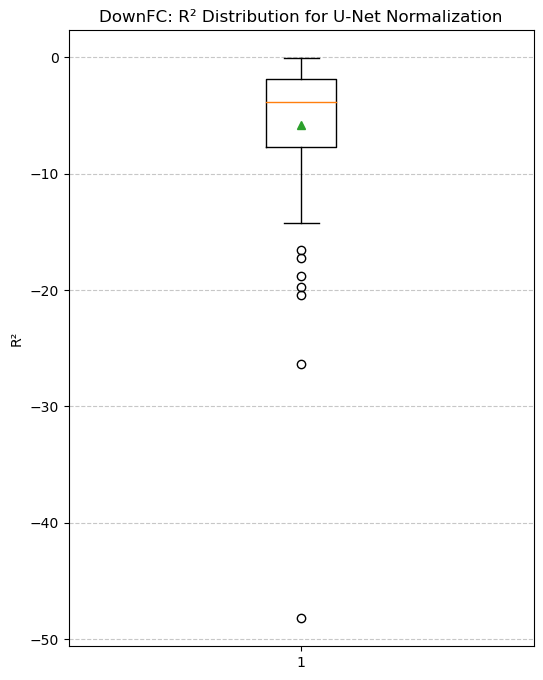

In [10]:
r2_all = r2_per_sample(HF_SGS_all_true.values, HF_SGS_all_pred.values)
plt.figure(figsize=(6, 8))
plt.boxplot(r2_all, vert=True, showmeans=True)
plt.ylabel("R²")
plt.title("DownFC: R² Distribution for U-Net Normalization")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Best case results (from SGS HF R2 values)

In [11]:
arr = r2_all

max_val = arr.max()        # get the minimum value
max_idx = arr.argmax()     # get the index of the minimum value

print("Maximum R2 value:", max_val)
print("Index of maximum:", max_idx)

Maximum R2 value: -0.06729466543543583
Index of maximum: 22


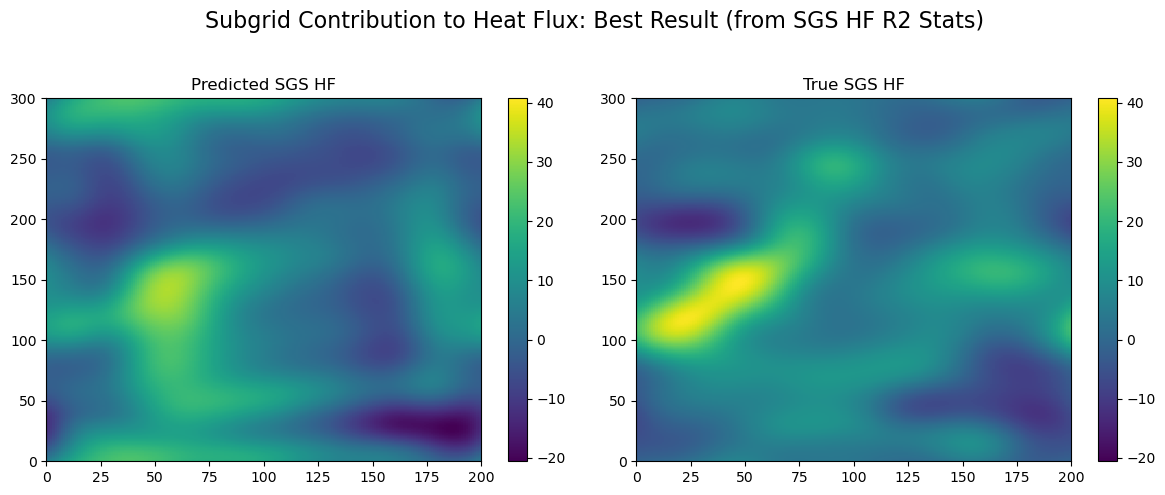

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=max_idx)
data2 = HF_SGS_all_true.isel(time=max_idx)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Best Result (from SGS HF R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

## Worst case results (from SGS HF R2 values)

In [13]:
arr = r2_all

min_val = arr.min()        # get the minimum value
min_idx = arr.argmin()     # get the index of the minimum value

print("Minimum R2 value:", min_val)
print("Index of minimum:", min_idx)

Minimum R2 value: -48.21792867313898
Index of minimum: 87


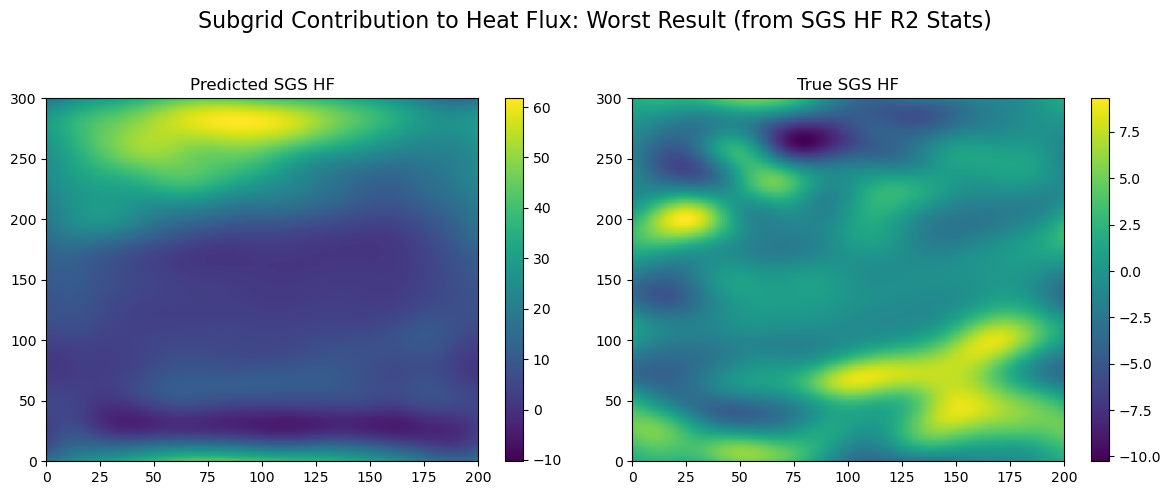

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=min_idx)
data2 = HF_SGS_all_true.isel(time=min_idx)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2) #, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Worst Result (from SGS HF R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

## Best Case Results (from downscaling R2 values)

In [16]:
max_idx_down = 78
min_idx_down = 19

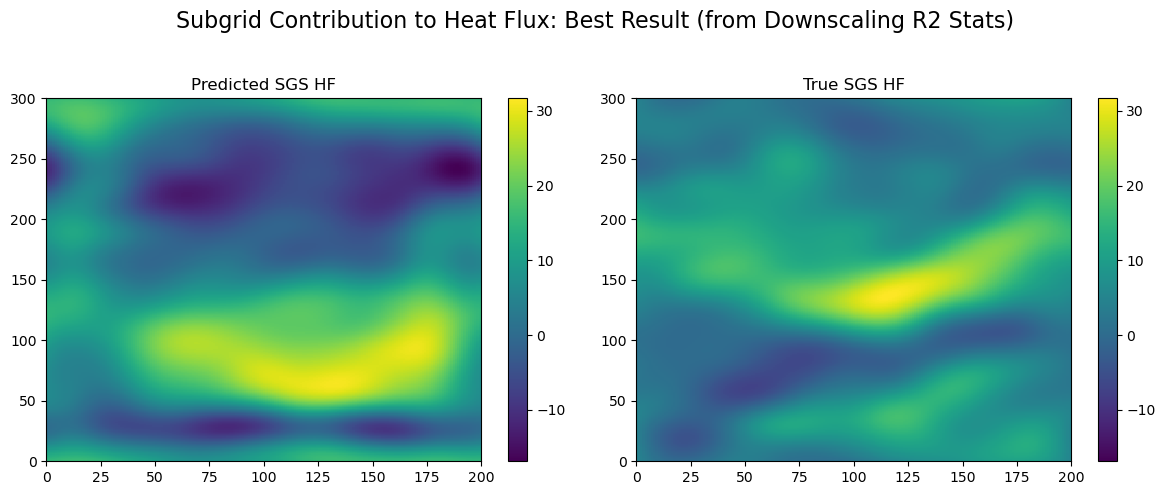

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=max_idx_down)
data2 = HF_SGS_all_true.isel(time=max_idx_down)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Best Result (from Downscaling R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

In [20]:
data1 = HF_SGS_all_pred.isel(time=max_idx_down)
data2 = HF_SGS_all_true.isel(time=max_idx_down)
r2(data1.values, data2.values)

-0.5425160861799052

## Worst Case Results (from downscaling R2 values)

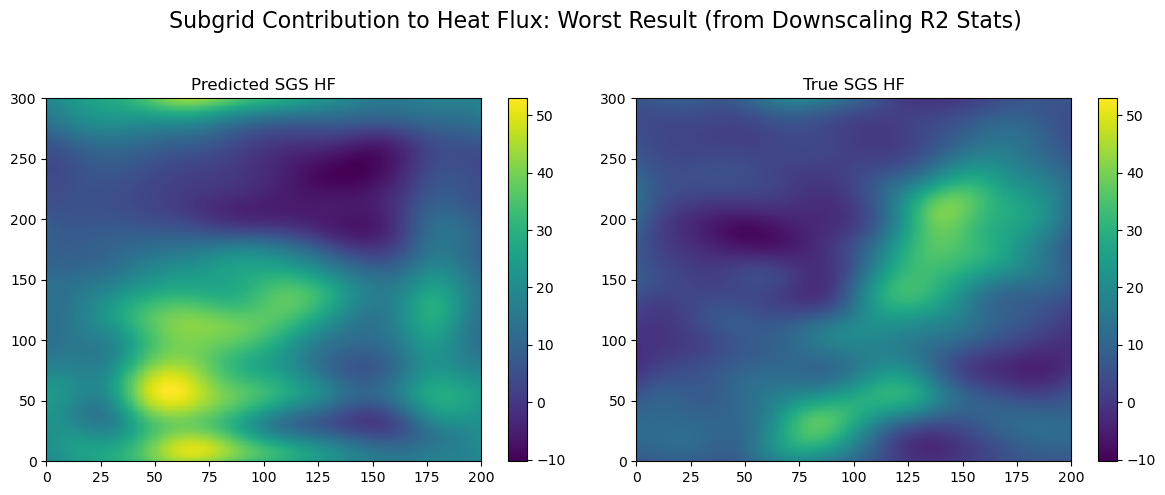

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=min_idx_down)
data2 = HF_SGS_all_true.isel(time=min_idx_down)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Worst Result (from Downscaling R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

In [19]:
data1 = HF_SGS_all_pred.isel(time=min_idx_down)
data2 = HF_SGS_all_true.isel(time=min_idx_down)
r2(data1.values, data2.values)

-0.6742070358495649